In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Conv2DTranspose, concatenate
from tensorflow import keras
from tensorflow.keras import regularizers

In [2]:
dataset_path = "/kaggle/input/brainstrokeresized/dataset1"
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                      batch_size=32,
                                                      label_mode="categorical",
                                                      shuffle=True,
                                                      color_mode="grayscale")
print(dataset.class_names)
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

Found 6650 files belonging to 3 classes.
['KanamaVeriSeti_PNG', 'inmeYokVeriSeti_PNG', 'iskemiVeriSeti_PNG']


In [3]:
shape =()
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels shape:", labels.shape)
    shape = images.shape[1:]

Train batch shape: (32, 256, 256, 1)
Train labels shape: (32, 3)


In [4]:
def get_unetpp(num_class=1, pretrained_weights="/kaggle/input/weighth5/tensorflow2/default/1/weight.h5",  deep_supervision=False):
    print('Begining UNet ++')
    nb_filter = [32, 64, 128, 256, 512]
    img_rows = 256
    img_cols = 256
    color_type = 1
    bn_axis = 3

    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    # img_input = Input(shape=x_train.shape[1:])

    conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(img_input)
    conv1_1 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(pool1)
    conv2_1 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12',
                            padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_2)
    conv1_2 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_2)

    conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(pool2)
    conv3_1 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22',
                            padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_2)
    conv2_2 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13',
                            padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13',axis=bn_axis)
    conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_3)
    conv1_3 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_3)

    conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(pool3)
    conv4_1 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32',
                            padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_2)
    conv3_2 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23',
                            padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23',axis=bn_axis)
    conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_3)
    conv2_3 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14',
                            padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_4)
    conv1_4 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_4)

    #     conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
    conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(pool4)
    conv5_1 = Conv2D(nb_filter[4], (3, 3), activation='relu', padding='same')(conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42',
                            padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_2)
    conv4_2 = Conv2D(nb_filter[3], (3, 3), activation='relu', padding='same')(conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33',
                            padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33',axis=bn_axis)
    conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_3)
    conv3_3 = Conv2D(nb_filter[2], (3, 3), activation='relu', padding='same')(conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24',
                            padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24',axis=bn_axis)
    conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_4)
    conv2_4 = Conv2D(nb_filter[1], (3, 3), activation='relu', padding='same')(conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15',
                            padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4],
                          name='merge15', axis=bn_axis)
    conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_5)
    conv1_5 = Conv2D(nb_filter[0], (3, 3), activation='relu', padding='same')(conv1_5)

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_1', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_2', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_3', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid',
                              name='output_4', kernel_initializer='he_normal',
                              padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_5)

    model = keras.Model(inputs=img_input, outputs=[nestnet_output_4])

    if (pretrained_weights):
        print ("loaded weights")
        model.load_weights(pretrained_weights)
    return model


In [5]:
strategy = tf.distribute.MirroredStrategy()

print("Number of GPUs:", strategy.num_replicas_in_sync)

Number of GPUs: 2


In [6]:
with strategy.scope():
    model = get_unetpp()
    for layer in model.layers[:-10]:
        layer.trainable = False  # Freeze all layers
    last_layer = model.outputs[-1]

# Add new layers for 3-class segmentation
    new_output = Conv2D(3, (1, 1), activation='relu', name='final_output')(last_layer)
    new_output1 = Flatten()(new_output)
    new_output2 = Dense(128, activation='relu', name='final_output1')(new_output1)
    new_output3 = Dense(3, activation='softmax', name='final_output2')(new_output2)

# Create a new model with the modified output
    model = keras.Model(inputs=model.input, outputs=new_output3)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Begining UNet ++
loaded weights


In [7]:
print(model.layers[:-10])

[<InputLayer name=main_input, built=True>, <Conv2D name=conv2d, built=True>, <Conv2D name=conv2d_1, built=True>, <MaxPooling2D name=pool1, built=True>, <Conv2D name=conv2d_2, built=True>, <Conv2D name=conv2d_3, built=True>, <MaxPooling2D name=pool2, built=True>, <Conv2D name=conv2d_6, built=True>, <Conv2D name=conv2d_7, built=True>, <MaxPooling2D name=pool3, built=True>, <Conv2D name=conv2d_12, built=True>, <Conv2D name=conv2d_13, built=True>, <MaxPooling2D name=pool4, built=True>, <Conv2D name=conv2d_20, built=True>, <Conv2D name=conv2d_21, built=True>, <Conv2DTranspose name=up42, built=True>, <Concatenate name=merge42, built=True>, <Conv2DTranspose name=up32, built=True>, <Conv2D name=conv2d_22, built=True>, <Concatenate name=merge32, built=True>, <Conv2DTranspose name=up22, built=True>, <Conv2D name=conv2d_23, built=True>, <Conv2D name=conv2d_14, built=True>, <Concatenate name=merge22, built=True>, <Conv2DTranspose name=up12, built=True>, <Conv2DTranspose name=up33, built=True>, <Co

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)   │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ main_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 32, 32, 128)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool4 (MaxPooling2D)      │ (None, 16, 16, 256)    │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ pool4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up42 (Conv2DTranspose)    │ (None, 32, 32, 256)    │        524,544 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merge42 (Concatenate)     │ (None, 32, 32, 512)    │              0 │ up42[0][0],            │
│                           │                        │                │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up32 (Conv2DTranspose)    │ (None, 64, 64, 128)    │        131,200 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 256)    │      1,179,904 │ merge42[0][0]          │
├──────────────────────

 Total params: 34,207,946 (130.49 MB)

 Trainable params: 25,460,554 (97.12 MB)

 Non-trainable params: 8,747,392 (33.37 MB)

In [9]:
history = model.fit(train_ds, epochs=100, batch_size=8, validation_data=val_ds)
model.save('/kaggle/working/UNETPP_Model_100epochs.keras')

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 133s 695ms/step - accuracy: 0.6665 - loss: 0.8452 - val_accuracy: 0.7593 - val_loss: 0.5921
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 120s 725ms/step - accuracy: 0.7887 - loss: 0.5348 - val_accuracy: 0.8236 - val_loss: 0.4727
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 122s 733ms/step - accuracy: 0.8924 - loss: 0.3144 - val_accuracy: 0.8535 - val_loss: 0.3917
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 119s 714ms/step - accuracy: 0.9520 - loss: 0.1668 - val_accuracy: 0.8565 - val_loss: 0.4001
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 123s 739ms/step - accuracy: 0.9843 - loss: 0.0752 - val_accuracy: 0.8714 - val_loss: 0.4039
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 122s 734ms/step - accuracy: 0.9967 - loss: 0.0363 - val_accuracy: 0.8879 - val_loss: 0.3707
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 120s 720ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.8625 - val_loss: 0.4359
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 120s 721ms/step - accuracy: 

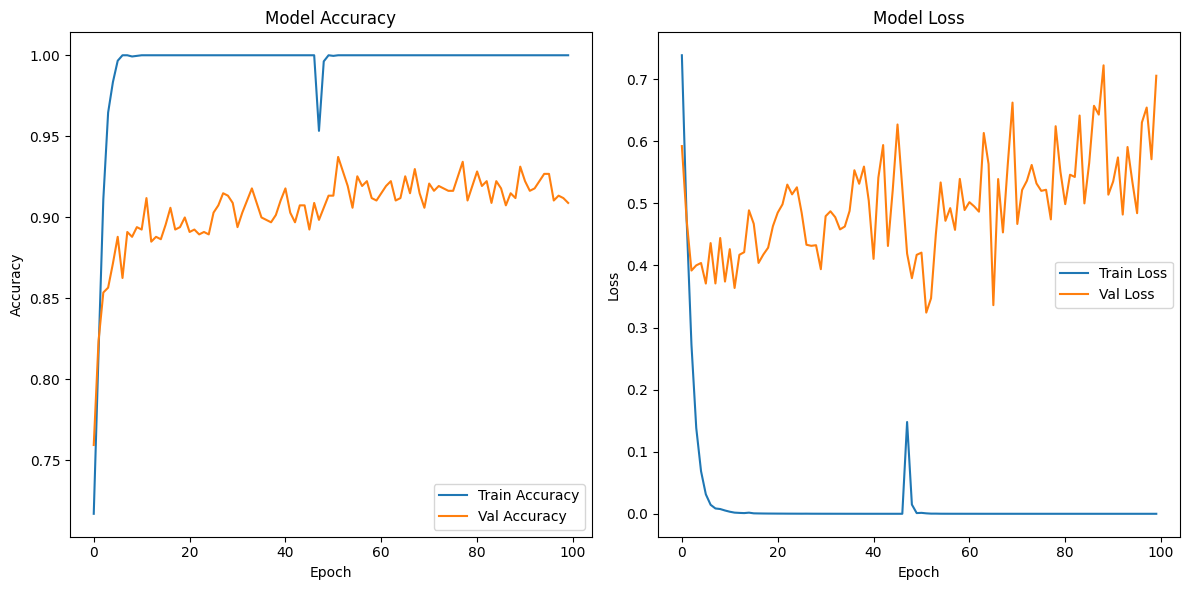

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
#plt.scatter(100, test_accuracy, color='r', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
#plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Accuracy')
#plt.scatter(100, test_loss, color='r', label='Test Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()